# core

> Some custom Torchvision tranforms.

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from typing import Any, Dict, Optional, List, Tuple
import random

from cjm_pil_utils.core import stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil


from PIL import Image

# Import PyTorch dependencies
import torch
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.datapoints import BoundingBox
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

Image Dims: (384, 512)


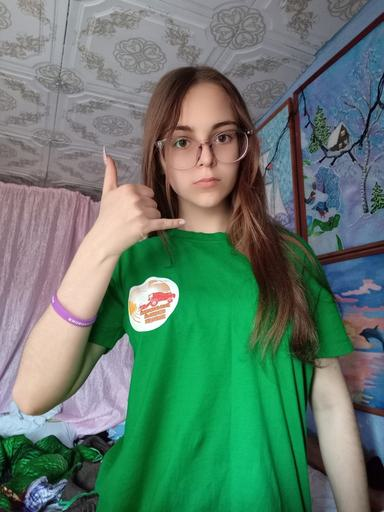

In [ ]:
img_path = './images/call-hand-gesture.png'

# Open the associated image file as a RGB image
sample_img = Image.open(img_path).convert('RGB')

# Print the dimensions of the image
print(f"Image Dims: {sample_img.size}")

# Show the image
sample_img

In [ ]:
#| export
class ResizeMax(transforms.Transform):
    """
    A PyTorch Transform class that resizes an image such that the maximum dimension 
    is equal to a specified size while maintaining the aspect ratio.
    
    Inherits from the PyTorch Transform class (transforms.Transform).

    Attributes:
    -----------
    max_sz : int
        The maximum size for any dimension (height or width) of the image.
    """
    
    def __init__(self, 
                 max_sz:int=256 # The maximum size for any dimension (height or width) of the image.
                ):
        """
        Initialize ResizeMax object with a specified max_sz. 
        """
        # Call to the parent class (Transform) constructor
        super().__init__()

        # Set the maximum size for any dimension of the image
        self.max_sz = max_sz
        
    def _transform(self, 
                   inpt: Any, # The input image tensor to be resized.
                   params: Dict[str, Any] # A dictionary of parameters. Not used in this method but is present for compatibility with the parent's method signature.
                  ) -> torch.Tensor: # The resized image tensor.
        """
        Apply the ResizeMax transformation on an input image tensor.
        """

        # Copy the input tensor to a new variable
        x = inpt

        # Get the width and height of the image tensor
        spatial_size = TF.get_spatial_size(x)

        # Calculate the size for the smaller dimension, such that the aspect ratio 
        # of the image is maintained when the larger dimension is resized to max_sz
        size = int(min(spatial_size) / (max(spatial_size) / self.max_sz))

        # Resize the image tensor with antialiasing for smoother output
        x = TF.resize(x, size=size, antialias=True)

        # Return the transformed (resized) image tensor
        return x

In [ ]:
target_sz = 384

Source image: (384, 512)
Image tensor: torch.Size([1, 3, 512, 384])
Padded tensor: torch.Size([1, 3, 384, 288])


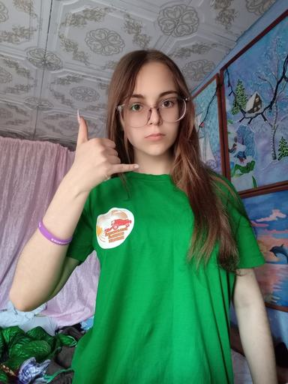

In [ ]:
print(f"Source image: {sample_img.size}")

# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=target_sz)

# Convert the cropped image to a tensor
img_tensor = transforms.PILToTensor()(sample_img)[None]
print(f"Image tensor: {img_tensor.shape}")

# Resize the tensor
resized_tensor = resize_max(img_tensor)
print(f"Padded tensor: {resized_tensor.shape}")

# Display the updated image
tensor_to_pil(resized_tensor)

In [ ]:
#| export
class PadSquare(transforms.Transform):
    """
    PadSquare is a PyTorch Transform class used to pad images to make them square. 
    Depending on the configuration, padding can be applied equally on both sides, 
    or can be randomly split between the two sides.
    
    Attributes:
        padding_mode (str): The method to use for padding. Default is 'constant'.
        fill (tuple): The RGB values to use for padding if padding_mode is 'constant'. Default is (123, 117, 104).
        shift (bool): If True, padding is randomly split between the two sides. If False, padding is equally applied. Default is True.
        pad_split (float): The proportion of padding applied to one side of the image. Only used when shift is True.
    """

    def __init__(self, 
                 padding_mode:str='constant', # The method to use for padding. Default is 'constant'.
                 fill:tuple=(123, 117, 104), # The RGB values to use for padding if padding_mode is 'constant'.
                 shift:bool=True # If True, padding is randomly split between the two sides. If False, padding is equally applied.
                ):
        """
        The constructor for PadSquare class.
        """
        super().__init__()
        self.padding_mode = padding_mode
        self.fill = fill
        self.shift = shift
        self.pad_split = None

    def forward(self, 
                *inputs: Any # The inputs to the forward method.
               ) -> Any: # The result of the superclass forward method.
        """
        The forward method that sets up the padding split factor if 'shift' is True, 
        and then calls the superclass forward method.
        """
        self.pad_split = random.random() if self.shift else None
        return super().forward(*inputs)

    def _transform(self, 
                   inpt: Any, # The input to be transformed.
                   params: Dict[str, Any] # A dictionary of parameters for the transformation.
                  ) -> Any: # The transformed input.
        """
        The _transform method that applies padding to the input to make it square.
        """
        x = inpt
        
        # Get the width and height of the image tensor
        h, w = TF.get_spatial_size(x)
        
        # If shift is true, padding is randomly split between two sides
        if self.shift:
            offset = (max(w, h) - min(w, h))
            pad_1 = int(offset*self.pad_split)
            pad_2 = offset - pad_1
            
            # The padding is applied to the shorter dimension of the image
            self.padding = [0, pad_1, 0, pad_2] if h < w else [pad_1, 0, pad_2, 0]
            padding = self.padding
        else:
            # If shift is false, padding is equally split between two sides
            offset = (max(w, h) - min(w, h)) // 2
            padding = [0, offset] if h < w else [offset, 0]
        
        # Apply the padding to the image
        x = TF.pad(x, padding=padding, padding_mode=self.padding_mode, fill=self.fill)
        
        return x

Resized tensor: torch.Size([3, 384, 288])
Padded tensor: torch.Size([3, 384, 384])


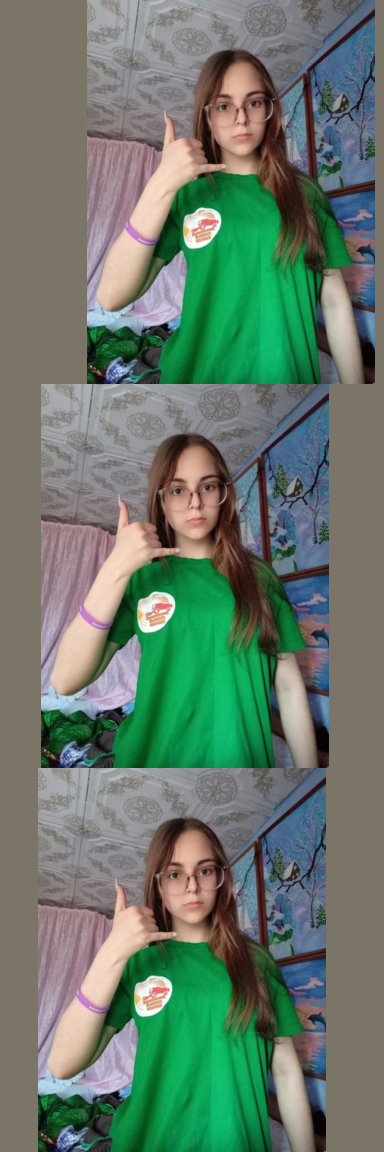

In [ ]:
print(f"Resized tensor: {resized_tensor.shape}")

# Create a `PadSquare` object
pad_square = PadSquare(shift=True)

# Pad the tensor
padded_tensor = pad_square(resized_tensor)
print(f"Padded tensor: {padded_tensor.shape}")

# Display the updated image
stack_imgs([tensor_to_pil(pad_square(resized_tensor)) for i in range(3)])

In [ ]:
#| export
class CustomTrivialAugmentWide(torchvision.transforms.TrivialAugmentWide):
    """
    This class extends the TrivialAugmentWide class provided by PyTorch's transforms module.
    TrivialAugmentWide is an augmentation policy randomly applies a single augmentation to each image.
    """
    def __init__(
        self,
        num_magnitude_bins: int = 31,
        interpolation: transforms.InterpolationMode = transforms.InterpolationMode.NEAREST,
        fill: Optional[List[float]] = None,
        op_meta: Optional[Dict[str, Tuple[torch.Tensor, bool]]] = None
    ) -> None:
        super().__init__(num_magnitude_bins, interpolation, fill)
        self.op_meta = op_meta if op_meta else super()._augmentation_space(num_bins)

    def _augmentation_space(self, 
                            num_bins: int
                           ) -> Dict[str, Tuple[torch.Tensor, bool]]:
        return self.op_meta

In [ ]:
num_bins = 31

custom_augmentation_space = {
    # Identity operation doesn't change the image
    "Identity": (torch.tensor(0.0), False),
            
    # Distort the image along the x or y axis, respectively.
    "ShearX": (torch.linspace(0.0, 0.25, num_bins), True),
    "ShearY": (torch.linspace(0.0, 0.25, num_bins), True),

    # Move the image along the x or y axis, respectively.
    "TranslateX": (torch.linspace(0.0, 32.0, num_bins), True),
    "TranslateY": (torch.linspace(0.0, 32.0, num_bins), True),

    # Rotate operation: rotates the image.
    "Rotate": (torch.linspace(0.0, 45.0, num_bins), True),

    # Adjust brightness, color, contrast,and sharpness respectively.
    "Brightness": (torch.linspace(0.0, 0.75, num_bins), True),
    "Color": (torch.linspace(0.0, 0.99, num_bins), True),
    "Contrast": (torch.linspace(0.0, 0.99, num_bins), True),
    "Sharpness": (torch.linspace(0.0, 0.99, num_bins), True),

    # Reduce the number of bits used to express the color in each channel of the image.
    "Posterize": (8 - (torch.arange(num_bins) / ((num_bins - 1) / 6)).round().int(), False),

    # Invert all pixel values above a threshold.
    "Solarize": (torch.linspace(255.0, 0.0, num_bins), False),

    # Maximize the image contrast by setting the darkest color to black and the lightest to white.
    "AutoContrast": (torch.tensor(0.0), False),

    # Equalize the image histogram to improve its contrast.
    "Equalize": (torch.tensor(0.0), False),
}

Augmented tensor: torch.Size([3, 384, 288])


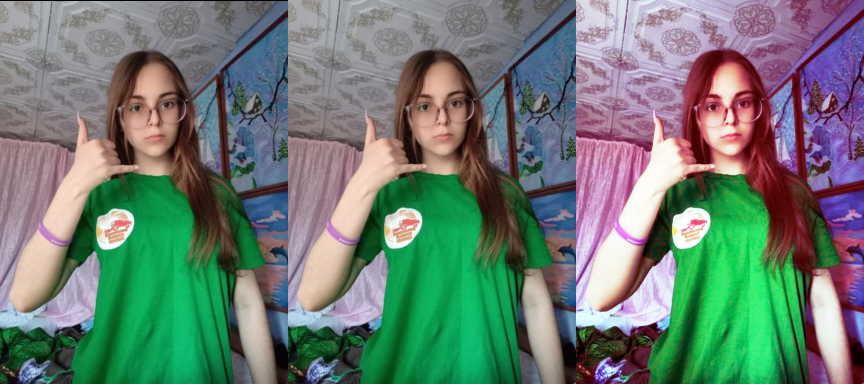

In [ ]:
# Create a `CustomTrivialAugmentWide` object
trivial_aug = CustomTrivialAugmentWide(op_meta=custom_augmentation_space)

# Pad the tensor
aug_tensor = trivial_aug(resized_tensor)
print(f"Augmented tensor: {aug_tensor.shape}")

# Display the updated image
stack_imgs([tensor_to_pil(trivial_aug(resized_tensor)) for i in range(3)])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()